In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import pandas as pd
import numpy as np
import torch
import torch_geometric as pyg
from tqdm.auto import *

from deepgd.model import Generator
from deepgd.data import GraphDrawingData
from deepgd.datasets import  RomeDataset

from deepgd.metrics import Stress

In [13]:
np.random.seed(721)
torch.manual_seed(721)
torch.cuda.manual_seed_all(721)

In [14]:
device = "cpu"
for backend, device_name in {
    torch.backends.mps: "mps",
    torch.cuda: "cuda",
}.items():
    if backend.is_available():
        device = device_name

/work/mlyang721/anaconda3/envs/deepgd/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
batch_size = 32
lr = 0.001
decay = 0.998

====================================================================================

##### ErdosRenyi Dataset

##### Rome Dataset

In [16]:
GraphDrawingData.set_optional_fields(["edge_pair_metaindex", "face", "rng"])
dataset = RomeDataset(
    index=pd.read_csv("assets/rome_index.txt", header=None)[0],
)
print(len(dataset))
layouts = np.load("assets/layouts/pmds.npy", allow_pickle=True)

inside init
raw_file_names
inside _parse_metadata


/work/mlyang721/anaconda3/envs/deepgd/lib/python3.10/site-packages/torch_geometric/data/dataset.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and to

processed_file_names
processed_file_names
processed_file_names


Transform graphs:   0%|          | 0/347 [00:00<?, ?it/s]

data dictionary size: 347
Graph erdos_renyi_20_0.2_graph_0 not found
Graph erdos_renyi_20_0.2_graph_1 not found
Graph erdos_renyi_20_0.2_graph_6 not found
347


====================================================================================

In [17]:

params = Generator.Params(
    num_blocks=11,
    block_depth=3,
    block_width=8,
    block_output_dim=8,
    edge_net_depth=2,
    edge_net_width=16,
    edge_attr_dim=2,
    node_attr_dim=2,
)
model = Generator(
    params=params,
).to(device)
criteria = {
    Stress(): 1,
    # dgd.EdgeVar(): 0,
    # dgd.Occlusion(): 0,
    # dgd.IncidentAngle(): 0,
    # dgd.TSNEScore(): 0,
}

In [18]:
optim = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=decay)

In [19]:
datalist = list(dataset)
for i, data in enumerate(datalist):
    data.pos = torch.tensor(layouts[i]).float()

In [20]:
train_loader = pyg.loader.DataLoader(datalist[:10000], batch_size=batch_size, shuffle=True)
val_loader = pyg.loader.DataLoader(datalist[11000:], batch_size=batch_size, shuffle=False)
# test_loader = pyg.loader.DataLoader(datalist[10000:11000], batch_size=batch_size, shuffle=False)
test_loader = pyg.loader.DataLoader(datalist[:300], batch_size=batch_size, shuffle=False)

In [21]:
import networkx as nx
def generate_init_pos(batch):
    # pos = torch.rand_like(batch.pos)
    print("batch.G",batch.G)
    combined_graph = batch.G[0]
    # Combine each subsequent graph
    for g in batch.G[1:]:
        combined_graph = nx.disjoint_union(combined_graph, g)
    pos = rescale_by_stress(
        # pos = torch.tensor(list(nx.spectral_layout(nx.compose(*batch.G)).values()), dtype=torch.float32),
        pos = torch.tensor(list(nx.spectral_layout(combined_graph).values()), dtype=torch.float32),
        apsp=batch.apsp_attr,
        edge_index=batch.perm_index,
        batch_index=batch.batch,
    )
    print(" shape after rescale_by_stress:", pos.shape)
    return pos

def get_edge_features(all_pair_shortest_path):
    return torch.cat([
        all_pair_shortest_path[:, None],
        1 / all_pair_shortest_path[:, None].square()
    ], dim=-1)

def rescale_by_stress(pos, apsp, edge_index, batch_index):  
    src_pos, dst_pos = pos[edge_index[0]], pos[edge_index[1]]
    dist = (dst_pos - src_pos).norm(dim=1)
    u_over_d = dist / apsp
    
    # Ensuring we cover all indices that pos might reference
    max_index = pos.size(0)
    scatterd_u_over_d_2 = pyg.utils.scatter(u_over_d ** 2, batch_index[edge_index[0]], dim_size=max_index)
    scatterd_u_over_d = pyg.utils.scatter(u_over_d, batch_index[edge_index[0]], dim_size=max_index)

    scale = scatterd_u_over_d_2 / scatterd_u_over_d
    
    # print("pos shape:", pos.shape)
    # print("scale shape:", scale.shape)
    # print("adjusted scale shape for operation:", scale[batch_index][:, None].shape)
    # print("Max edge index:", torch.max(edge_index).item())
    # print("Number of positions available:", pos.size(0))

    scaled_pos = pos / scale[:, None]
    # print("Shape of scaled positions:", scaled_pos.shape)

    return scaled_pos

In [22]:
model.load_state_dict(torch.load("model_359.pt", map_location=device))

/tmp/ipykernel_39924/3491819972.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_359.pt", map_location=device))


<All keys matched successfully>

In [23]:
# for epoch in range(1000):
for epoch in range(0):
    model.train()
    losses = []
    for batch in tqdm(train_loader):
        batch = batch.to(device)
        model.zero_grad()
        loss = 0
        for c, w in criteria.items():
            pred = model(
                init_pos=generate_init_pos(batch),
                edge_index=batch.perm_index,
                edge_attr=get_edge_features(batch.apsp_attr),
                batch_index=batch.batch,
            )
            pos = rescale_by_stress(pred, batch.apsp_attr, batch.perm_index, batch.batch)
            loss += w * c(pos, batch.perm_index, batch.apsp_attr, batch.batch)
        loss.backward()
        optim.step()
        losses.append(loss.item())
    scheduler.step()
    print(f'[Epoch {epoch}] Train Loss: {np.mean(losses)}')
    with torch.no_grad():
        model.eval()
        losses = []
        for batch in tqdm(val_loader, disable=True):
            batch = batch.to(device)
            loss = 0
            for c, w in criteria.items():
                pred = model(
                    init_pos=generate_init_pos(batch),
                    edge_index=batch.perm_index,
                    edge_attr=get_edge_features(batch.apsp_attr),
                    batch_index=batch.batch,
                )
                pos = rescale_by_stress(pred, batch.apsp_attr, batch.perm_index, batch.batch)
                loss += w * c(pos, batch.perm_index, batch.apsp_attr, batch.batch)
            losses.append(loss.item())
        print(f'[Epoch {epoch}] Val Loss: {np.mean(losses)}')

================================ DEBUG ================================

In [29]:
with torch.no_grad():
    model.eval()
    losses = []
    for batch in tqdm(test_loader, disable=True):
        print(batch)
        batch = batch.to(device)
        
        # print("Batch size:", batch.batch.size())
        # print("perm index shape:", batch.perm_index.shape)
        # print("apsp_attr shape:", batch.apsp_attr.shape)


        loss = 0
        for c, w in criteria.items():

            pred = model(
                init_pos=generate_init_pos(batch),
                edge_index=batch.perm_index,
                edge_attr=get_edge_features(batch.apsp_attr),
                batch_index=batch.batch,
            )
            pos = rescale_by_stress(pred, batch.apsp_attr, batch.perm_index, batch.batch)
            loss += w * c(pos, batch.perm_index, batch.apsp_attr, batch.batch)
        losses.append(loss.item())
    print(f'Test Loss: {np.mean(losses)}')

GraphDrawingDataBatch(G=[32], perm_index=[2, 12160], edge_metaindex=[4360], apsp_attr=[12160], perm_weight=[12160], aggr_metaindex=[12160], pos=[1535, 2], name=[32], n=[32], m=[32], edge_pair_metaindex=[2, 78937], num_nodes=640, batch=[640], ptr=[33])
batch.G [<networkx.classes.digraph.DiGraph object at 0x7f6c9ee24550>, <networkx.classes.digraph.DiGraph object at 0x7f6c9ee25810>, <networkx.classes.digraph.DiGraph object at 0x7f6c9ee26680>, <networkx.classes.digraph.DiGraph object at 0x7f6c9efcb940>, <networkx.classes.digraph.DiGraph object at 0x7f6c9ee266e0>, <networkx.classes.digraph.DiGraph object at 0x7f6c9ee26770>, <networkx.classes.digraph.DiGraph object at 0x7f6c9ee26800>, <networkx.classes.digraph.DiGraph object at 0x7f6c9ee26890>, <networkx.classes.digraph.DiGraph object at 0x7f6c9ee26920>, <networkx.classes.digraph.DiGraph object at 0x7f6c9ee269b0>, <networkx.classes.digraph.DiGraph object at 0x7f6c9ee26a40>, <networkx.classes.digraph.DiGraph object at 0x7f6c9ee26ad0>, <networ

KeyboardInterrupt: 

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f8c789d99f0>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5c430>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5f220>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5e920>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5f730>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5d840>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5d780>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5f100>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5e680>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5d2a0>, <networkx.classes.digraph.DiGraph object at 0x7f8f7db11c90>, <networkx.classes.digraph.DiGraph object at 0x7f8c911ecb50>, <networkx.classes.digraph.DiGraph object at 0x7f8c911efca0>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b4c160>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b4cb50>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b4cbb0>, <networkx.class

/tmp/ipykernel_68720/3220903253.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  pos = torch.tensor(list(nx.spectral_layout(combined_graph).values()), dtype=torch.float32),


 shape after rescale_by_stress: torch.Size([640, 2])
inside visualize_graph_v2 [<networkx.classes.digraph.DiGraph object at 0x7f8c789d99f0>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5c430>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5f220>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5e920>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5f730>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5d840>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5d780>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5f100>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5e680>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b5d2a0>, <networkx.classes.digraph.DiGraph object at 0x7f8f7db11c90>, <networkx.classes.digraph.DiGraph object at 0x7f8c911ecb50>, <networkx.classes.digraph.DiGraph object at 0x7f8c911efca0>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b4c160>, <networkx.classes.digraph.DiGraph object at 0x7f8c82b4cb50>, <netw

/work/mlyang721/anaconda3/envs/deepgd/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


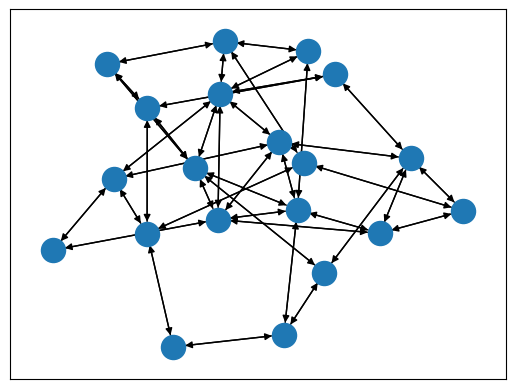

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f8c82872740>, <networkx.classes.digraph.DiGraph object at 0x7f8c82870730>, <networkx.classes.digraph.DiGraph object at 0x7f8c82871930>, <networkx.classes.digraph.DiGraph object at 0x7f8c828719c0>, <networkx.classes.digraph.DiGraph object at 0x7f8c82871cc0>, <networkx.classes.digraph.DiGraph object at 0x7f8c82870f70>, <networkx.classes.digraph.DiGraph object at 0x7f8c82873d60>, <networkx.classes.digraph.DiGraph object at 0x7f8c82873610>, <networkx.classes.digraph.DiGraph object at 0x7f8c82871390>, <networkx.classes.digraph.DiGraph object at 0x7f8c82870070>, <networkx.classes.digraph.DiGraph object at 0x7f8c82870370>, <networkx.classes.digraph.DiGraph object at 0x7f8c828735b0>, <networkx.classes.digraph.DiGraph object at 0x7f8c82870400>, <networkx.classes.digraph.DiGraph object at 0x7f8ca047da50>, <networkx.classes.digraph.DiGraph object at 0x7f8ca047e4a0>, <networkx.classes.digraph.DiGraph object at 0x7f8ca047e980>, <networkx.class

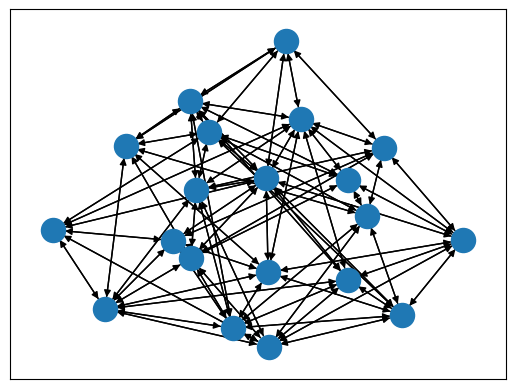

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f8c910cdae0>, <networkx.classes.digraph.DiGraph object at 0x7f8c910cf280>, <networkx.classes.digraph.DiGraph object at 0x7f8c910ccb80>, <networkx.classes.digraph.DiGraph object at 0x7f8c910ce9b0>, <networkx.classes.digraph.DiGraph object at 0x7f8c910ce8f0>, <networkx.classes.digraph.DiGraph object at 0x7f8c910ce890>, <networkx.classes.digraph.DiGraph object at 0x7f8c910ce410>, <networkx.classes.digraph.DiGraph object at 0x7f8c910ce590>, <networkx.classes.digraph.DiGraph object at 0x7f8c910cddb0>, <networkx.classes.digraph.DiGraph object at 0x7f8c910cf460>, <networkx.classes.digraph.DiGraph object at 0x7f8c910ce830>, <networkx.classes.digraph.DiGraph object at 0x7f8c910cf5b0>, <networkx.classes.digraph.DiGraph object at 0x7f8c911c2860>, <networkx.classes.digraph.DiGraph object at 0x7f8c911c1840>, <networkx.classes.digraph.DiGraph object at 0x7f8c911c1060>, <networkx.classes.digraph.DiGraph object at 0x7f8c911c09a0>, <networkx.class

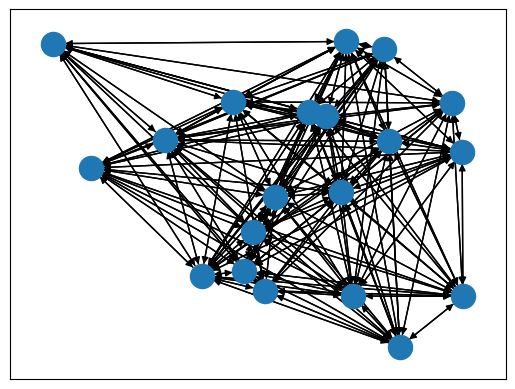

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f8d53b30790>, <networkx.classes.digraph.DiGraph object at 0x7f8d53b31750>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf7d30>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf7eb0>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf79d0>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf75b0>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf7970>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf7760>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf6c50>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf69b0>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf6bc0>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf6a40>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf5e70>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf6110>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf68f0>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf7d00>, <networkx.class

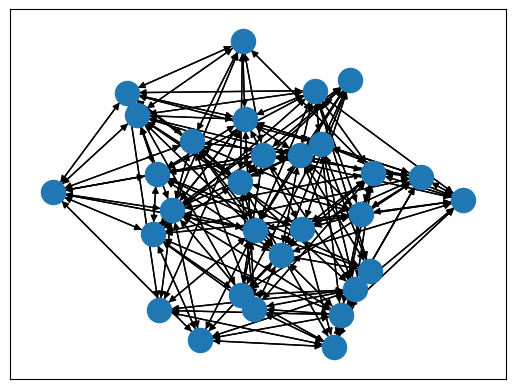

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f8c80bf7400>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf77f0>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf7490>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf6bf0>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf6f20>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf6c80>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf6a10>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf65c0>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf6650>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf6920>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf6740>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf5c60>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf6aa0>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf79a0>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf6b00>, <networkx.classes.digraph.DiGraph object at 0x7f8c80bf43a0>, <networkx.class

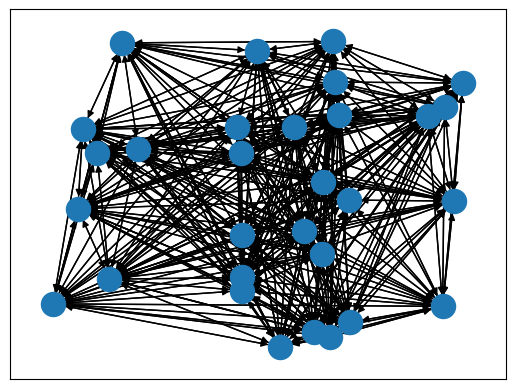

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f8c789d0070>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d11b0>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d2d40>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d1ae0>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d2080>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d3a30>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d36a0>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d22f0>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d0dc0>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d0160>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d2140>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d2bf0>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d1720>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d3610>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d13f0>, <networkx.classes.digraph.DiGraph object at 0x7f8c789d1270>, <networkx.class

StopIteration: 

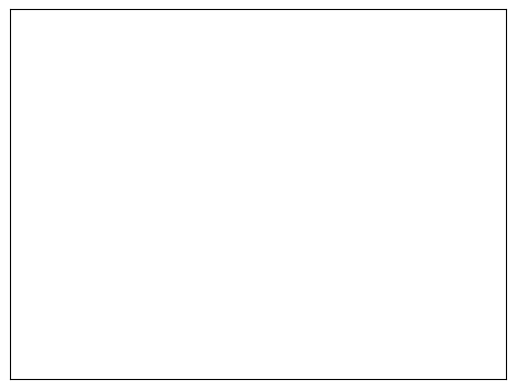

In [33]:
import numpy as np
import matplotlib.pyplot as plt
def visualize_graph_v2(batch, perm_index, apsp_attr, pos=None):
    print("inside visualize_graph_v2", batch.G)
    total = 0
    for G in batch.G:
        total += G.number_of_nodes()
    print("total",total)
    print("dimension of shape", pos.shape)

    x = 0
    for i in range(len(batch.G)):
        print(i, pos[x:x+batch.G[i].number_of_nodes()])
        nx.draw_networkx(batch.G[i], pos=pos[x:x+batch.G[i].number_of_nodes()], with_labels=False, cmap="Set2")
        # print("print(pos): ----",pos.shape)
        # pos = pos[batch.G[i].number_of_nodes():]
        # print("print(pos): ----",pos.shape)
        x += batch.G[i].number_of_nodes()
        break

    plt.show()
    # return g2
    return batch.G[0]

with torch.no_grad():
    model.eval()
    losses = []
    
    for batch in tqdm(test_loader, disable=True):
        # print(batch)
        batch = batch.to(device)
        
        # print("Batch size:", batch.batch.size())
        # print("perm index shape:", batch.perm_index.shape)
        # print("apsp_attr shape:", batch.apsp_attr.shape)

        loss = 0
        for c, w in criteria.items():
            pred = model(
                init_pos=generate_init_pos(batch),
                edge_index=batch.perm_index,
                edge_attr=get_edge_features(batch.apsp_attr),
                batch_index=batch.batch,
            )
            # print("pred: ", pred)
            pos = rescale_by_stress(pred, batch.apsp_attr, batch.perm_index, batch.batch)
            
            loss += w * c(pos, batch.perm_index, batch.apsp_attr, batch.batch)

        losses.append(loss.item())
        
        visualize_graph_v2(batch, batch.perm_index.cpu().numpy(), batch.apsp_attr.cpu().numpy(), pred)

    print(f'Test Loss: {np.mean(losses)}')


batch.G [<networkx.classes.digraph.DiGraph object at 0x7fac49b04c10>, <networkx.classes.digraph.DiGraph object at 0x7fac49b05f60>, <networkx.classes.digraph.DiGraph object at 0x7fac49b06d70>, <networkx.classes.digraph.DiGraph object at 0x7fac49b04ca0>, <networkx.classes.digraph.DiGraph object at 0x7fac49b06dd0>, <networkx.classes.digraph.DiGraph object at 0x7fac49b06e60>, <networkx.classes.digraph.DiGraph object at 0x7fac49b06ef0>, <networkx.classes.digraph.DiGraph object at 0x7fac49b06f80>, <networkx.classes.digraph.DiGraph object at 0x7fac49b07010>, <networkx.classes.digraph.DiGraph object at 0x7fac49b070a0>, <networkx.classes.digraph.DiGraph object at 0x7fac49b07130>, <networkx.classes.digraph.DiGraph object at 0x7fac49b071c0>, <networkx.classes.digraph.DiGraph object at 0x7fac49b07250>, <networkx.classes.digraph.DiGraph object at 0x7fac49b072e0>, <networkx.classes.digraph.DiGraph object at 0x7fac49b07370>, <networkx.classes.digraph.DiGraph object at 0x7fac49b07400>, <networkx.class

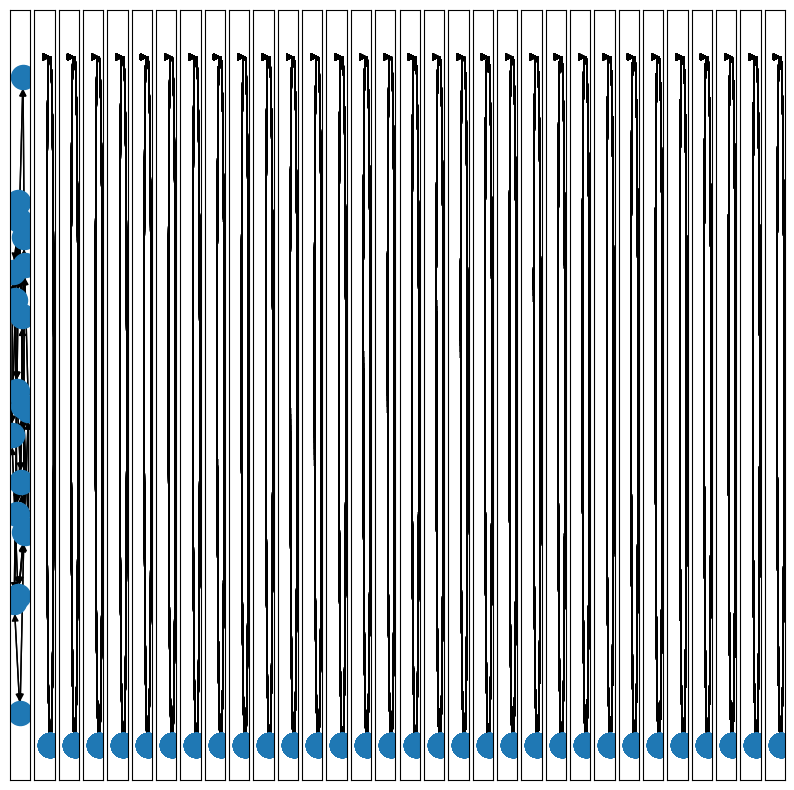

batch.G [<networkx.classes.digraph.DiGraph object at 0x7fac49b07d90>, <networkx.classes.digraph.DiGraph object at 0x7fac49b07e20>, <networkx.classes.digraph.DiGraph object at 0x7fac49b07eb0>, <networkx.classes.digraph.DiGraph object at 0x7fac49b07f40>, <networkx.classes.digraph.DiGraph object at 0x7fac49b07fd0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f40a0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f4130>, <networkx.classes.digraph.DiGraph object at 0x7fac490f41c0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f4250>, <networkx.classes.digraph.DiGraph object at 0x7fac490f42e0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f4370>, <networkx.classes.digraph.DiGraph object at 0x7fac490f4400>, <networkx.classes.digraph.DiGraph object at 0x7fac490f4490>, <networkx.classes.digraph.DiGraph object at 0x7fac490f4520>, <networkx.classes.digraph.DiGraph object at 0x7fac490f45b0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f4640>, <networkx.class

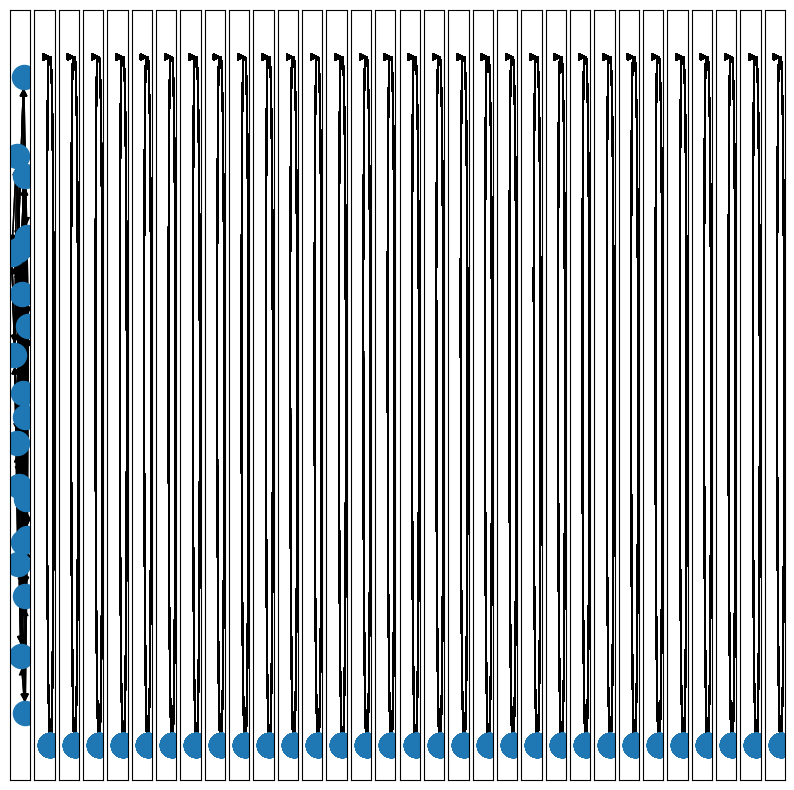

batch.G [<networkx.classes.digraph.DiGraph object at 0x7fac490f4fd0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f5060>, <networkx.classes.digraph.DiGraph object at 0x7fac490f50f0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f5180>, <networkx.classes.digraph.DiGraph object at 0x7fac490f5210>, <networkx.classes.digraph.DiGraph object at 0x7fac490f52a0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f5330>, <networkx.classes.digraph.DiGraph object at 0x7fac490f53c0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f5450>, <networkx.classes.digraph.DiGraph object at 0x7fac490f54e0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f5570>, <networkx.classes.digraph.DiGraph object at 0x7fac490f5600>, <networkx.classes.digraph.DiGraph object at 0x7fac490f5690>, <networkx.classes.digraph.DiGraph object at 0x7fac490f5720>, <networkx.classes.digraph.DiGraph object at 0x7fac490f57b0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f5840>, <networkx.class

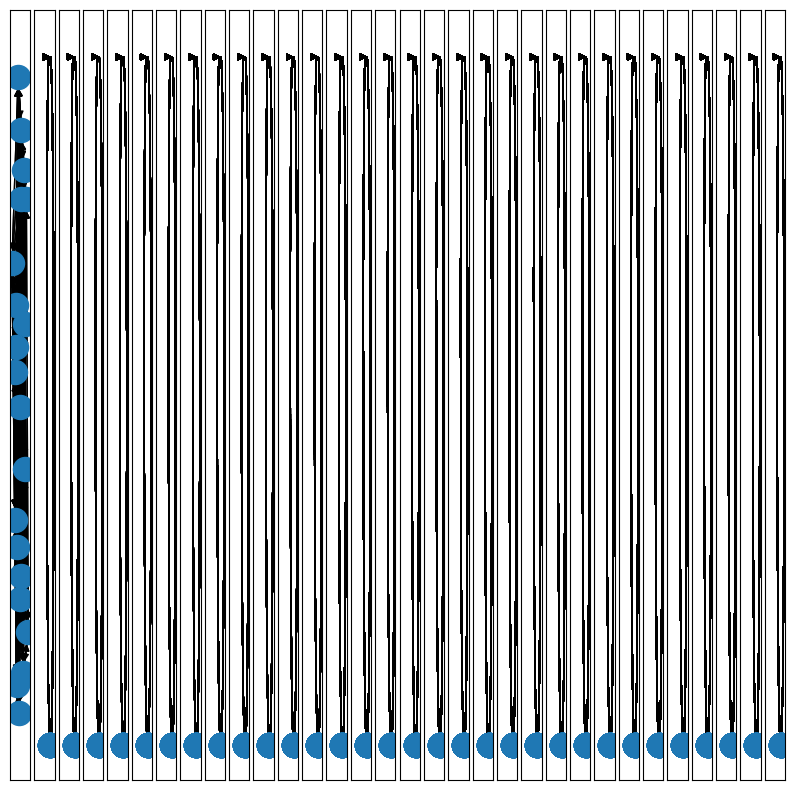

batch.G [<networkx.classes.digraph.DiGraph object at 0x7fac490f61d0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f6260>, <networkx.classes.digraph.DiGraph object at 0x7fac490f62f0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f6380>, <networkx.classes.digraph.DiGraph object at 0x7fac490f6410>, <networkx.classes.digraph.DiGraph object at 0x7fac490f64a0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f6530>, <networkx.classes.digraph.DiGraph object at 0x7fac490f65c0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f6650>, <networkx.classes.digraph.DiGraph object at 0x7fac490f66e0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f6770>, <networkx.classes.digraph.DiGraph object at 0x7fac490f6800>, <networkx.classes.digraph.DiGraph object at 0x7fac490f6890>, <networkx.classes.digraph.DiGraph object at 0x7fac490f6920>, <networkx.classes.digraph.DiGraph object at 0x7fac490f69b0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f6a40>, <networkx.class

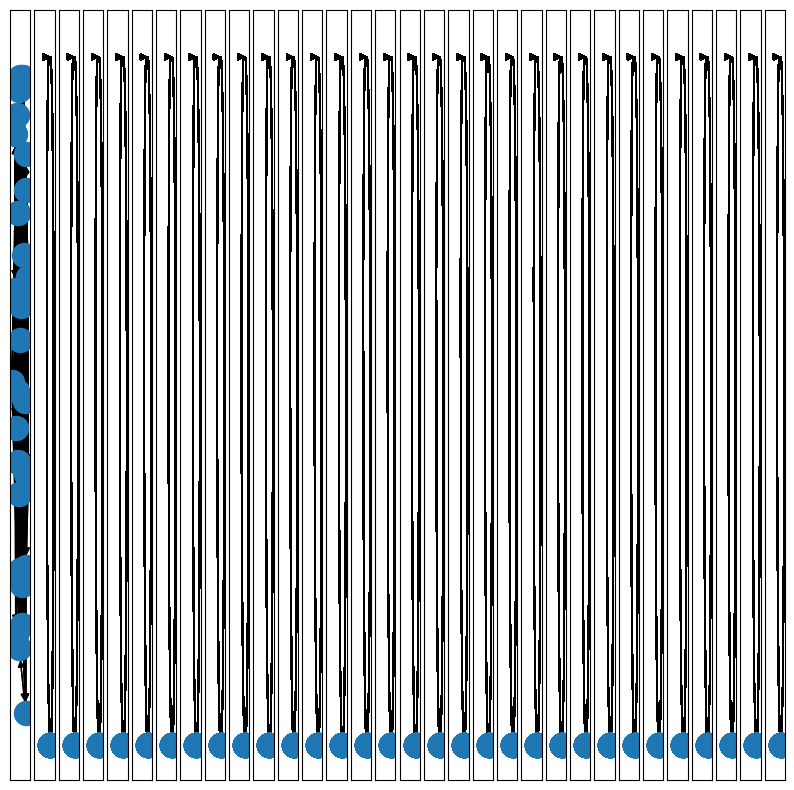

batch.G [<networkx.classes.digraph.DiGraph object at 0x7fac490f73d0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f7460>, <networkx.classes.digraph.DiGraph object at 0x7fac490f74f0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f7580>, <networkx.classes.digraph.DiGraph object at 0x7fac490f7610>, <networkx.classes.digraph.DiGraph object at 0x7fac490f76a0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f7730>, <networkx.classes.digraph.DiGraph object at 0x7fac490f77c0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f7850>, <networkx.classes.digraph.DiGraph object at 0x7fac490f78e0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f7970>, <networkx.classes.digraph.DiGraph object at 0x7fac490f7a00>, <networkx.classes.digraph.DiGraph object at 0x7fac490f7a90>, <networkx.classes.digraph.DiGraph object at 0x7fac490f7b20>, <networkx.classes.digraph.DiGraph object at 0x7fac490f7bb0>, <networkx.classes.digraph.DiGraph object at 0x7fac490f7c40>, <networkx.class

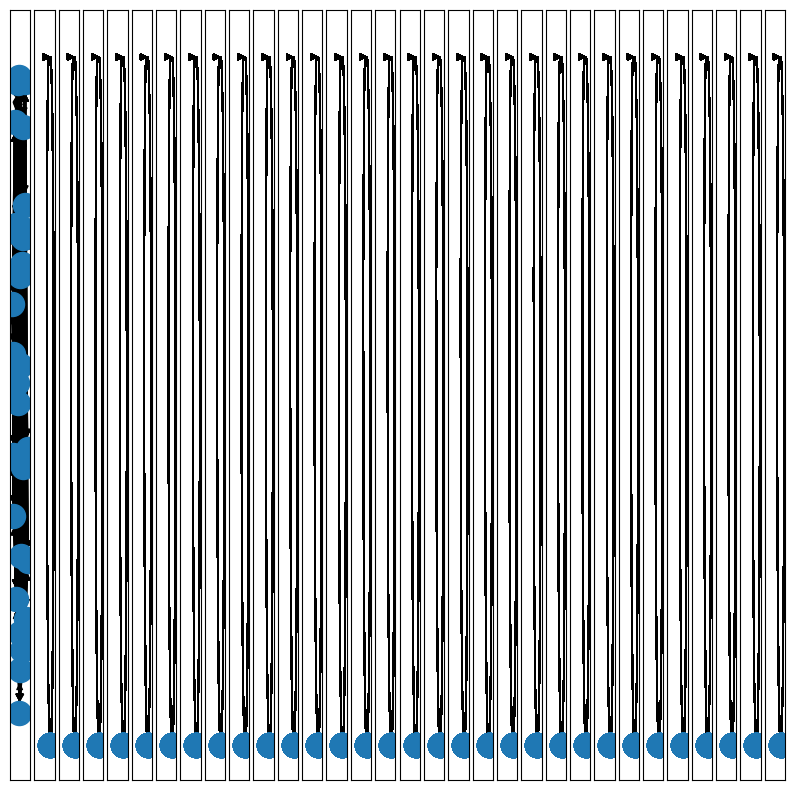

batch.G [<networkx.classes.digraph.DiGraph object at 0x7fac4859c610>, <networkx.classes.digraph.DiGraph object at 0x7fac4859c6a0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859c730>, <networkx.classes.digraph.DiGraph object at 0x7fac4859c7c0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859c850>, <networkx.classes.digraph.DiGraph object at 0x7fac4859c8e0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859c970>, <networkx.classes.digraph.DiGraph object at 0x7fac4859ca00>, <networkx.classes.digraph.DiGraph object at 0x7fac4859ca90>, <networkx.classes.digraph.DiGraph object at 0x7fac4859cb20>, <networkx.classes.digraph.DiGraph object at 0x7fac4859cbb0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859cc40>, <networkx.classes.digraph.DiGraph object at 0x7fac4859ccd0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859cd60>, <networkx.classes.digraph.DiGraph object at 0x7fac4859cdf0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859ce80>, <networkx.class

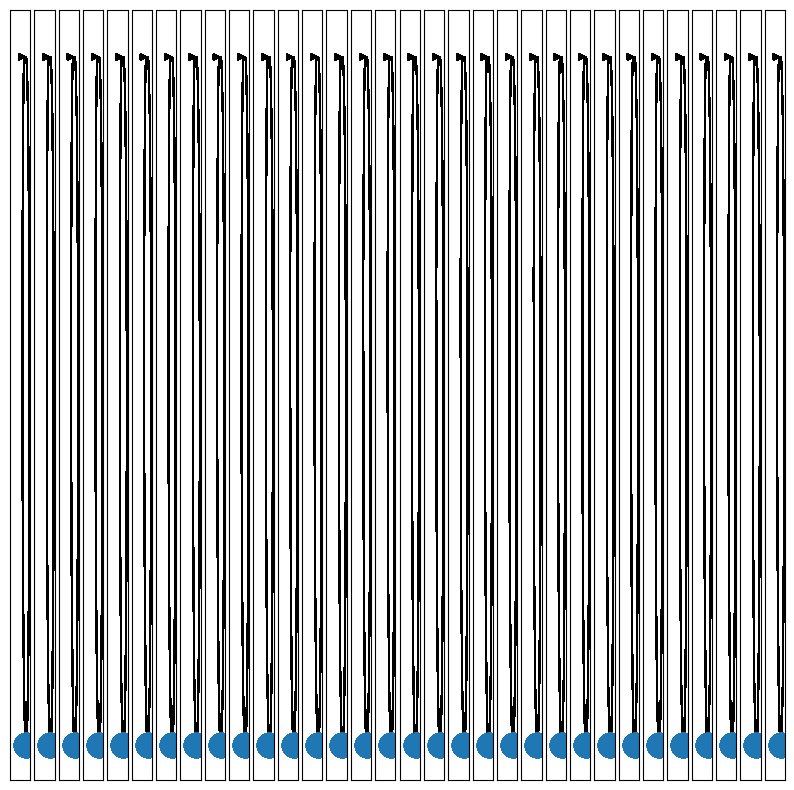

batch.G [<networkx.classes.digraph.DiGraph object at 0x7fac4859d900>, <networkx.classes.digraph.DiGraph object at 0x7fac4859d990>, <networkx.classes.digraph.DiGraph object at 0x7fac4859da20>, <networkx.classes.digraph.DiGraph object at 0x7fac4859dab0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859db10>, <networkx.classes.digraph.DiGraph object at 0x7fac4859dba0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859dc30>, <networkx.classes.digraph.DiGraph object at 0x7fac4859dcc0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859dd50>, <networkx.classes.digraph.DiGraph object at 0x7fac4859dde0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859de70>, <networkx.classes.digraph.DiGraph object at 0x7fac4859df00>, <networkx.classes.digraph.DiGraph object at 0x7fac4859df90>, <networkx.classes.digraph.DiGraph object at 0x7fac4859e020>, <networkx.classes.digraph.DiGraph object at 0x7fac4859e0b0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859e1d0>, <networkx.class

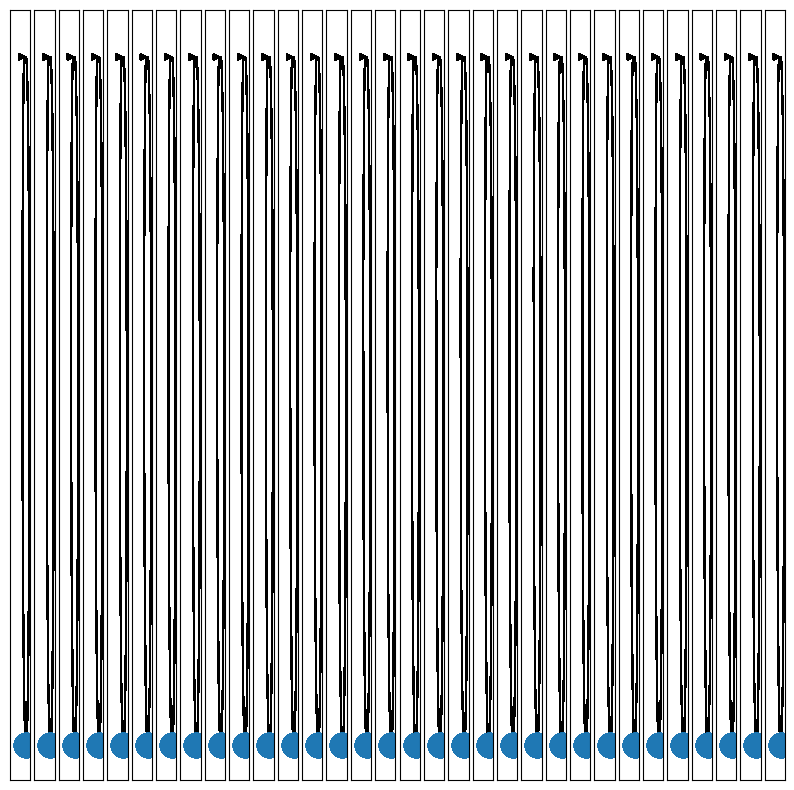

batch.G [<networkx.classes.digraph.DiGraph object at 0x7fac4859eb60>, <networkx.classes.digraph.DiGraph object at 0x7fac4859ebf0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859ec80>, <networkx.classes.digraph.DiGraph object at 0x7fac4859ed10>, <networkx.classes.digraph.DiGraph object at 0x7fac4859eda0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859ee30>, <networkx.classes.digraph.DiGraph object at 0x7fac4859eec0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859ef50>, <networkx.classes.digraph.DiGraph object at 0x7fac4859efe0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859f070>, <networkx.classes.digraph.DiGraph object at 0x7fac4859f100>, <networkx.classes.digraph.DiGraph object at 0x7fac4859f190>, <networkx.classes.digraph.DiGraph object at 0x7fac4859f220>, <networkx.classes.digraph.DiGraph object at 0x7fac4859f2b0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859f340>, <networkx.classes.digraph.DiGraph object at 0x7fac4859f3d0>, <networkx.class

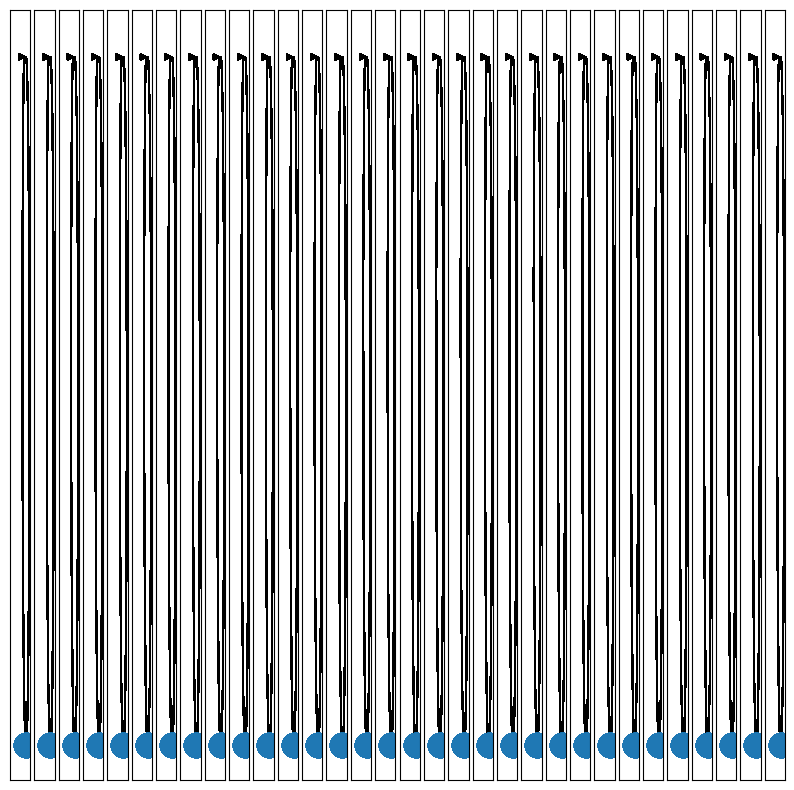

batch.G [<networkx.classes.digraph.DiGraph object at 0x7fac4859fd60>, <networkx.classes.digraph.DiGraph object at 0x7fac4859fdf0>, <networkx.classes.digraph.DiGraph object at 0x7fac4859fe80>, <networkx.classes.digraph.DiGraph object at 0x7fac4859ff10>, <networkx.classes.digraph.DiGraph object at 0x7fac4859ffa0>, <networkx.classes.digraph.DiGraph object at 0x7fac469f0070>, <networkx.classes.digraph.DiGraph object at 0x7fac469f0100>, <networkx.classes.digraph.DiGraph object at 0x7fac469f0190>, <networkx.classes.digraph.DiGraph object at 0x7fac469f0220>, <networkx.classes.digraph.DiGraph object at 0x7fac469f02b0>, <networkx.classes.digraph.DiGraph object at 0x7fac469f0340>, <networkx.classes.digraph.DiGraph object at 0x7fac469f03d0>, <networkx.classes.digraph.DiGraph object at 0x7fac469f0460>, <networkx.classes.digraph.DiGraph object at 0x7fac469f04f0>, <networkx.classes.digraph.DiGraph object at 0x7fac469f0580>, <networkx.classes.digraph.DiGraph object at 0x7fac469f0610>, <networkx.class

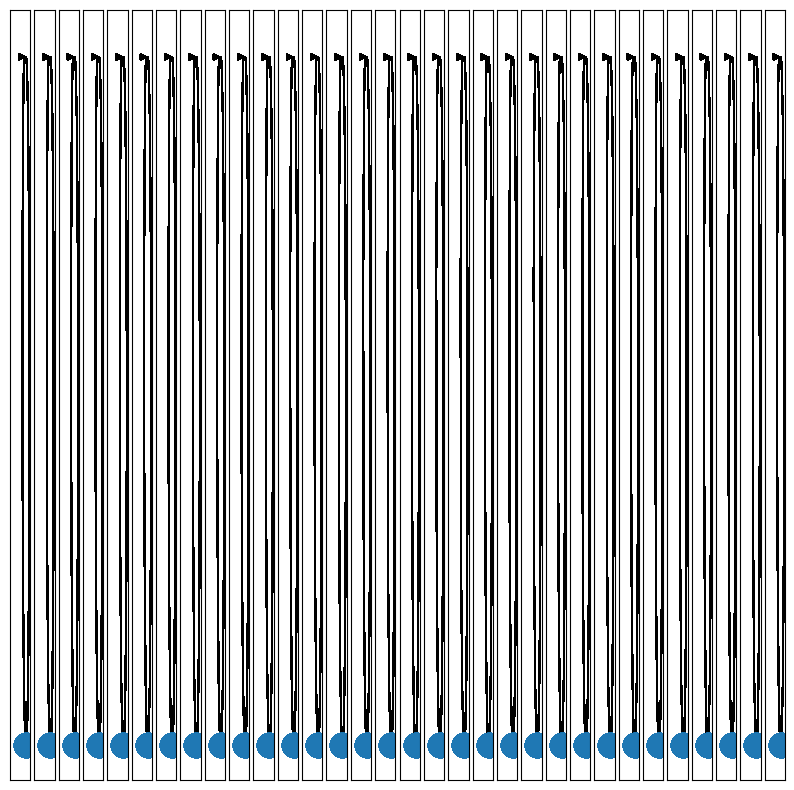

batch.G [<networkx.classes.digraph.DiGraph object at 0x7fac469f0e50>, <networkx.classes.digraph.DiGraph object at 0x7fac469f0ee0>, <networkx.classes.digraph.DiGraph object at 0x7fac469f0f70>, <networkx.classes.digraph.DiGraph object at 0x7fac469f1000>, <networkx.classes.digraph.DiGraph object at 0x7fac469f1090>, <networkx.classes.digraph.DiGraph object at 0x7fac469f1120>, <networkx.classes.digraph.DiGraph object at 0x7fac469f11b0>, <networkx.classes.digraph.DiGraph object at 0x7fac469f1240>, <networkx.classes.digraph.DiGraph object at 0x7fac469f12d0>, <networkx.classes.digraph.DiGraph object at 0x7fac469f1360>, <networkx.classes.digraph.DiGraph object at 0x7fac469f13f0>, <networkx.classes.digraph.DiGraph object at 0x7fac469f1480>]
 shape after rescale_by_stress: torch.Size([960, 2])
inside visualize_graph_v2 [<networkx.classes.digraph.DiGraph object at 0x7fac469f0e50>, <networkx.classes.digraph.DiGraph object at 0x7fac469f0ee0>, <networkx.classes.digraph.DiGraph object at 0x7fac469f0f7

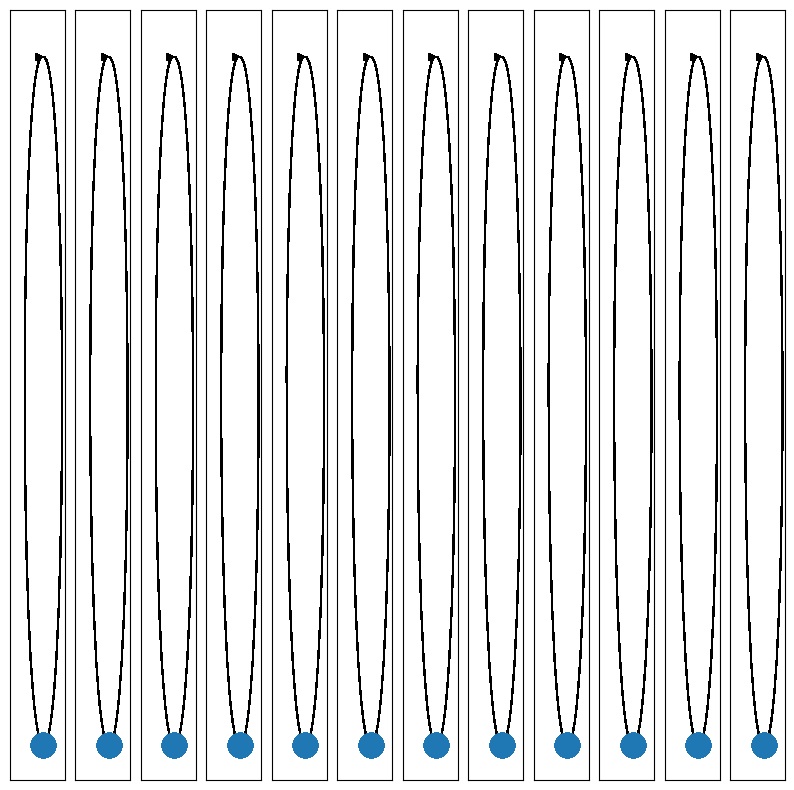

Test Loss: nan


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph_v2(batch, perm_index, apsp_attr, pos=None):
    print("inside visualize_graph_v2", batch.G)
    total = 0
    for G in batch.G:
        total += G.number_of_nodes()
    print("total", total)
    print("dimension of shape", pos.shape)

    x = 0
    plt.figure(figsize=(10, 10))
    num_graphs = len(batch.G)

    for i in range(num_graphs):
        plt.subplot(1, num_graphs, i+1) 
        graph_pos = pos[x:x + batch.G[i].number_of_nodes()]

        if torch.isnan(graph_pos).any():
            print(f"Warning: NaN values found in graph {i} positions! Replacing NaN values with (0,0).")
            graph_pos = torch.nan_to_num(graph_pos, nan=0.0)

        print(i, graph_pos)
        nx.draw_networkx(batch.G[i], pos=graph_pos.numpy(), with_labels=False, cmap="Set2")
        x += batch.G[i].number_of_nodes()

    plt.show()

    return batch.G[0]


# Testing the modificatio n inside the main loop
with torch.no_grad():
    model.eval()
    losses = []

    for batch in tqdm(test_loader, disable=True):
        batch = batch.to(device)

        loss = 0
        for c, w in criteria.items():
            pred = model(
                init_pos=generate_init_pos(batch),
                edge_index=batch.perm_index,
                edge_attr=get_edge_features(batch.apsp_attr),
                batch_index=batch.batch,
            )
            pos = rescale_by_stress(pred, batch.apsp_attr, batch.perm_index, batch.batch)
            loss += w * c(pos, batch.perm_index, batch.apsp_attr, batch.batch)

        losses.append(loss.item())

        visualize_graph_v2(batch, batch.perm_index.cpu().numpy(), batch.apsp_attr.cpu().numpy(), pred)

    print(f'Test Loss: {np.mean(losses)}')

